In [1]:
# %pip install-r requirements.txt

**Note**: This demo is adapted from the LXMERT Demo present here: https://github.com/huggingface/transformers/tree/main/examples/research_projects/lxmert

In [2]:
import io

import numpy as np
import PIL.Image
import torch
from IPython.display import Image, display
from modeling_frcnn import GeneralizedRCNN
from processing_image import Preprocess
from visualizing_image import SingleImageViz

import utils
from transformers import BertTokenizerFast, VisualBertForQuestionAnswering
from utils import Config


# URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/images/input.jpg"
URL = "https://vqa.cloudcv.org/media/test2014/COCO_test2014_000000262567.jpg"
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
VQA_URL = "https://dl.fbaipublicfiles.com/pythia/data/answers_vqa.txt"


# for visualizing output
def showarray(a, fmt="jpeg"):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

2021-08-11 04:32:30.532299: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
# load object, attribute, and answer labels

objids = utils.get_data(OBJ_URL)
attrids = utils.get_data(ATTR_URL)
vqa_answers = utils.get_data(VQA_URL)

In [4]:
# load models and model components
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")

frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

image_preprocess = Preprocess(frcnn_cfg)

bert_tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
visualbert_vqa = VisualBertForQuestionAnswering.from_pretrained("uclanlp/visualbert-vqa")

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/crocoder/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


/home/crocoder/anaconda3/envs/transformers_env/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


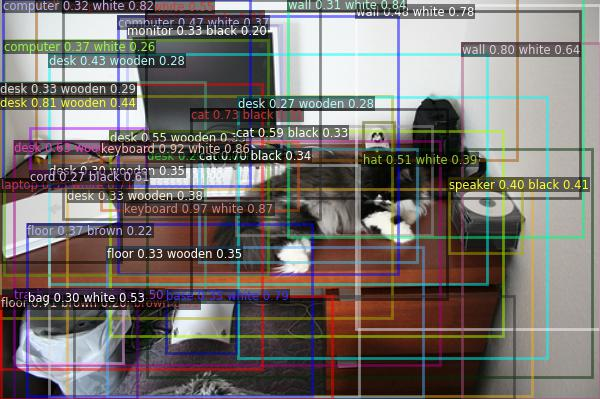

In [5]:
# image viz
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)
# run frcnn
images, sizes, scales_yx = image_preprocess(URL)
output_dict = frcnn(
    images,
    sizes,
    scales_yx=scales_yx,
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt",
)
# add boxes and labels to the image

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())

In [6]:
# test_questions_for_url1 = [
#     "Where is this scene?",
#     "what is the man riding?",
#     "What is the man wearing?",
#     "What is the color of the horse?"
# ]
test_questions_for_url2 = [
    "Where is the cat?",
    "What is near the disk?",
    "What is the color of the table?",
    "What is the color of the cat?",
    "What is the shape of the monitor?",
]

# Very important that the boxes are normalized
# normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")

In [7]:
for test_question in test_questions_for_url2:
    test_question = [test_question]

    inputs = bert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt",
    )

    output_vqa = visualbert_vqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_embeds=features,
        visual_attention_mask=torch.ones(features.shape[:-1]),
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_vqa = output_vqa["logits"].argmax(-1)
    print("Question:", test_question)
    print("prediction from VisualBert VQA:", vqa_answers[pred_vqa])

Question: ['Where is the cat?']
prediction from VisualBert VQA: outside
Question: ['What is near the disk?']
prediction from VisualBert VQA: nothing
Question: ['What is the color of the table?']
prediction from VisualBert VQA: brown
Question: ['What is the color of the cat?']
prediction from VisualBert VQA: gray
Question: ['What is the shape of the monitor?']
prediction from VisualBert VQA: square
